In [1]:
from qiskit.ml.datasets import *
from qiskit import QuantumCircuit
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector
%matplotlib inline

In [2]:
# constants
n = 4
class_labels = ['yes', 'no']

In [3]:
def normalizeData(DATA_PATH = "../../Data/Processed/data.csv"):
    """
    Normalizes the data
    """
    # Reads the data
    data = pd.read_csv(DATA_PATH)
    X, Y = data[['sex', 'cp', 'exang', 'oldpeak']].values, data['num'].values
    # normalize the data
    X = normalize(X)
    return X, Y

In [4]:
X, Y = normalizeData()

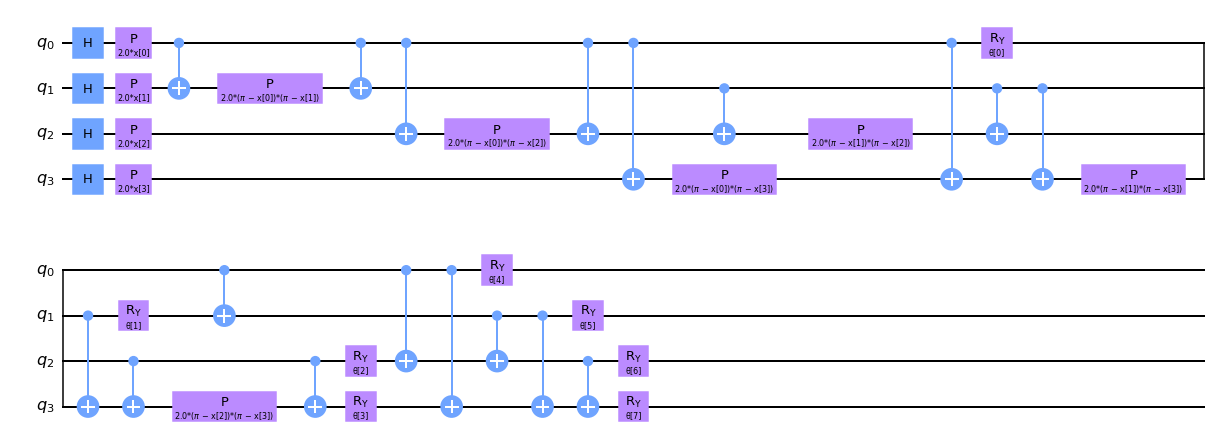

In [5]:
sv = Statevector.from_label('0' * n)
feature_map = ZZFeatureMap(n, reps=1)
var_form = RealAmplitudes(n, reps=1)
circuit = feature_map.combine(var_form)
circuit.draw(output='mpl')

In [6]:
def get_data_dict(params, x):
    parameters = {}
    for i, p in enumerate(feature_map.ordered_parameters):
        parameters[p] = x[i]
    for i, p in enumerate(var_form.ordered_parameters):
        parameters[p] = params[i]
    return parameters

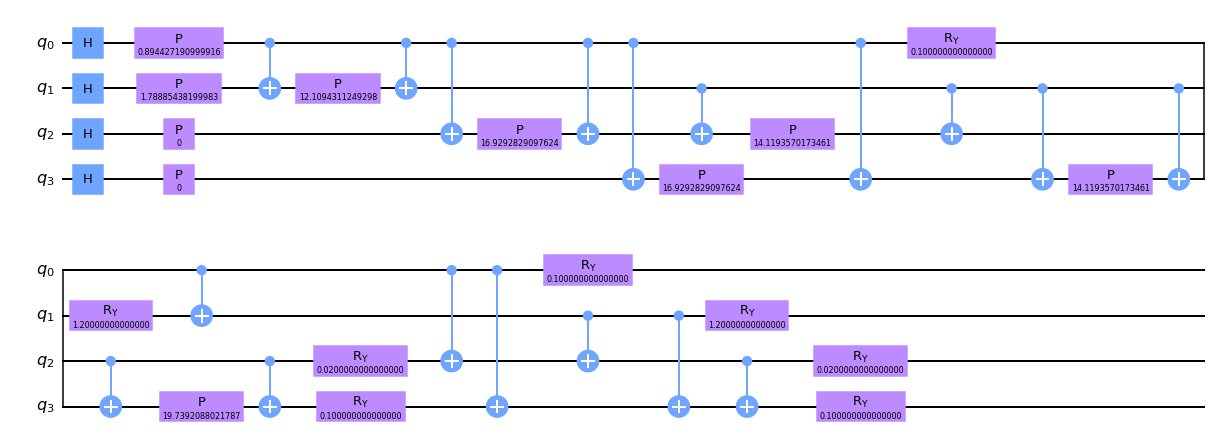

In [7]:
data = X[0]
params = np.array([0.1, 1.2, 0.02, 0.1, 0.1, 1.2, 0.02, 0.1])
circ_ = circuit.assign_parameters(get_data_dict(params, data))
circ_.draw(plot_barriers=True)

In [8]:
def assign_label(bit_string, class_labels):
    hamming_weight = sum([int(k) for k in list(bit_string)])
    is_odd_parity = hamming_weight & 1
    if is_odd_parity:
        return class_labels[1]
    else:
        return class_labels[0]

In [9]:
def return_probabilities(counts, class_labels):
    shots = sum(counts.values())
    result = {class_labels[0]: 0,
    class_labels[1]: 0}
    for key, item in counts.items():
        label = assign_label(key, class_labels)
        result[label] += counts[key]/shots
    return result

In [10]:
return_probabilities({'00' : 10, '01': 10, '11': 20}, class_labels)


{'yes': 0.75, 'no': 0.25}

In [11]:
def classify(x_list, params, class_labels):
    qc_list = []
    for x in x_list:
        circ_ = circuit.assign_parameters(get_data_dict(params, x))
        qc = sv.evolve(circ_)
        qc_list += [qc]
        probs = []
    for qc in qc_list:
        counts = qc.to_counts()
        prob = return_probabilities(counts, class_labels)
        probs += [prob]
    return probs

In [12]:
x = np.asarray([X[0]])
classify(x, params=np.array([0.8, -0.5, 1.5, 0,5, 0.8, -0.5, 1.5, 0,5]), class_labels=class_labels)

/home/r0x6f736f646f/Documents/VENVS/qosf/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The `Statevector.to_counts` method is deprecated as of 0.13.0, and will be removed no earlier than 3 months after that release date. You should use the `Statevector.probabilities_dict` method instead.
  if __name__ == '__main__':


[{'yes': 0.6338620140853923, 'no': 0.3661379859146076}]

In [13]:
def cost_estimate_sigmoid(probs, expected_label): # probability of labels vs actual labels
    p = probs.get(expected_label)
    sig = None
    if np.isclose(p, 0.0):
        sig = 1
    elif np.isclose(p, 1.0):
        sig = 0
    else:
        denominator = np.sqrt(2*p*(1-p))
        x = np.sqrt(200)*(0.5-p)/denominator
        sig = 1/(1+np.exp(-x))
    return sig

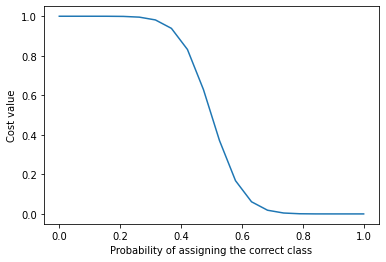

In [14]:
x = np.linspace(0, 1, 20)
y = [cost_estimate_sigmoid({'A': x_, 'B': 1-x_}, 'A') for x_ in x]
plt.plot(x, y)
plt.xlabel('Probability of assigning the correct class')
plt.ylabel('Cost value')
plt.show()

In [15]:
def cost_function(X, Y, class_labels, params, shots=100, print_value=False):
    # map training input to list of labels and list of samples
    cost = 0
    training_labels = []
    training_samples = []
    for sample in X:
        training_samples += [sample]
    for label in Y:
        if label == 0:
            training_labels += [class_labels[0]]
        elif label == 1:
            training_labels += [class_labels[1]]
    probs = classify(training_samples, params, class_labels)
    # evaluate costs for all classified samples
    for i, prob in enumerate(probs):
        cost += cost_estimate_sigmoid(prob, training_labels[i])
    cost /= len(training_samples)
    # print resulting objective function
    if print_value:
        print('%.4f' % cost)
    # return objective value
    return cost

In [16]:
cost_function(X, Y, class_labels, params)

/home/r0x6f736f646f/Documents/VENVS/qosf/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The `Statevector.to_counts` method is deprecated as of 0.13.0, and will be removed no earlier than 3 months after that release date. You should use the `Statevector.probabilities_dict` method instead.
  if __name__ == '__main__':


0.3602514611661046

In [17]:
optimizer = COBYLA(maxiter=100)
# define objective function for training
objective_function = lambda params: cost_function(X, Y, class_labels, params, print_value=True)
# randomly initialize the parameters
np.random.seed(42)
init_params = 2*np.pi*np.random.rand(n*(1)*2)
# train classifier
opt_params, value, _ = optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
# print results
print()
print('opt_params:', opt_params)
print('opt_value: ', value)

/home/r0x6f736f646f/Documents/VENVS/qosf/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The `Statevector.to_counts` method is deprecated as of 0.13.0, and will be removed no earlier than 3 months after that release date. You should use the `Statevector.probabilities_dict` method instead.
  if __name__ == '__main__':


0.5576
0.6009
0.5668
0.5865
0.4392
0.5744
0.3956
0.4861
0.4008
0.5274
0.4135
0.4020
0.4014
0.3915
0.3899
0.3789
0.3665
0.3487
0.3275
0.3278
0.3385
0.3780
0.3343
0.3254
0.3160
0.3137
0.3043
0.2776
0.2718
0.2673
0.2687
0.2634
0.2665
0.2650
0.2662
0.2810
0.2563
0.2588
0.2570
0.2588
0.2557
0.2565
0.2586
0.2566
0.2570
0.2573
0.2506
0.2450
0.2404
0.2436
0.2418
0.2407
0.2409
0.2371
0.2397
0.2363
0.2351
0.2392
0.2295
0.2275
0.2291
0.2272
0.2300
0.2274
0.2283
0.2266
0.2254
0.2315
0.2271
0.2253
0.2235
0.2230
0.2232
0.2229
0.2227
0.2221
0.2226
0.2224
0.2233
0.2212
0.2216
0.2214
0.2210
0.2204
0.2199
0.2205
0.2199
0.2201
0.2204
0.2194
0.2187
0.2187
0.2187
0.2186
0.2190
0.2181
0.2179
0.2178
0.2173
0.2175

opt_params: [ 2.50223425  7.28019605  5.12759583  3.269959    0.66849624  2.15607395
 -0.50773612  5.57337858]
opt_value:  0.2173496482708948


In [16]:
# collect coordinates of test data
test_label_0_x = [x[0] for x in test_input[class_labels[0]]]
test_label_0_y = [x[1] for x in test_input[class_labels[0]]]
test_label_1_x = [x[0] for x in test_input[class_labels[1]]]
test_label_1_y = [x[1] for x in test_input[class_labels[1]]]
# initialize lists for misclassified datapoints
test_label_misclassified_x = []
test_label_misclassified_y = []

# evaluate test data
for label, samples in test_input.items():
    # classify samples
    results = classify(samples, opt_params, class_labels)
    # analyze results
    for i, result in enumerate(results):
        # assign label
        assigned_label = class_labels[np.argmax([p for p in result.values()])]
        print('----------------------------------------------------')
        print('Data point: ', samples[i])
        print('Label: ', label)
        print('Assigned: ', assigned_label)
        print('Probabilities: ', result)
        if label != assigned_label:
            print('Classification:', 'INCORRECT')
            test_label_misclassified_x += [samples[i][0]]
            test_label_misclassified_y += [samples[i][1]]
        else:
            print('Classification:', 'CORRECT')
# compute fraction of misclassified samples
total = len(test_label_0_x) + len(test_label_1_x)
num_misclassified = len(test_label_misclassified_x)
print()
print(100*(1-num_misclassified/total), "% of the test data was correctly classified!")

/home/r0x6f736f646f/Documents/VENVS/qosf/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The `Statevector.to_counts` method is deprecated as of 0.13.0, and will be removed no earlier than 3 months after that release date. You should use the `Statevector.probabilities_dict` method instead.
  if __name__ == '__main__':


----------------------------------------------------
Data point:  [6.03185789 1.19380521]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.5643741727917417, 'B': 0.4356258272082583}
Classification: CORRECT
----------------------------------------------------
Data point:  [0.43982297 0.18849556]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.8309454333623649, 'B': 0.16905456663763507}
Classification: CORRECT
----------------------------------------------------
Data point:  [5.52920307 4.58672527]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.770259656158106, 'B': 0.22974034384189396}
Classification: CORRECT
----------------------------------------------------
Data point:  [0.25132741 3.58141563]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.7254718487170333, 'B': 0.2745281512829667}
Classification: CORRECT
----------------------------------------------------
Data point:  [5.71769863 0.06283185]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.8460372999778406, 'B': 0.1539627000221593}
Cla

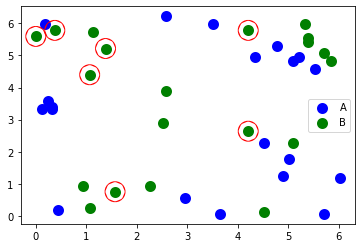

In [17]:
plt.figure()
plt.scatter(test_label_0_x, test_label_0_y, c='b', label=class_labels[0], linewidths=5)
plt.scatter(test_label_1_x, test_label_1_y, c='g', label=class_labels[1], linewidths=5)
plt.scatter(test_label_misclassified_x, test_label_misclassified_y, linewidths=20, s=1, facecolors='none', edgecolors='r')
plt.legend()
plt.show()